In [5]:
import numpy as np
import pandas as pd

In [7]:
cancer_df.columns

Index(['Patient_ID', 'Age', 'Gender', 'Country_Region', 'Year', 'Genetic_Risk',
       'Air_Pollution', 'Alcohol_Use', 'Smoking', 'Obesity_Level',
       'Cancer_Type', 'Cancer_Stage', 'Treatment_Cost_USD', 'Survival_Years',
       'Target_Severity_Score'],
      dtype='object')

In [8]:
bankrupt_df.columns

Index(['Bankrupt?', ' ROA(C) before interest and depreciation before interest',
       ' ROA(A) before interest and % after tax',
       ' ROA(B) before interest and depreciation after tax',
       ' Operating Gross Margin', ' Realized Sales Gross Margin',
       ' Operating Profit Rate', ' Pre-tax net Interest Rate',
       ' After-tax net Interest Rate',
       ' Non-industry income and expenditure/revenue',
       ' Continuous interest rate (after tax)', ' Operating Expense Rate',
       ' Research and development expense rate', ' Cash flow rate',
       ' Interest-bearing debt interest rate', ' Tax rate (A)',
       ' Net Value Per Share (B)', ' Net Value Per Share (A)',
       ' Net Value Per Share (C)', ' Persistent EPS in the Last Four Seasons',
       ' Cash Flow Per Share', ' Revenue Per Share (Yuan ¥)',
       ' Operating Profit Per Share (Yuan ¥)',
       ' Per Share Net profit before tax (Yuan ¥)',
       ' Realized Sales Gross Profit Growth Rate',
       ' Operating Profit

In [7]:
# CS7641 Supervised Learning Report — Jupyter Notebook Version
import os, json, time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.model_selection import StratifiedKFold, learning_curve, cross_val_predict
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier

RANDOM_STATE = 42
OUTDIR = "outputs"
os.makedirs(OUTDIR, exist_ok=True)


In [10]:
def bin_severity(y_cont: pd.Series, bins: int = 3) -> pd.Series:
    return pd.qcut(y_cont, q=bins, labels=False, duplicates='drop')

def preprocess_cancer(df: pd.DataFrame, target_bins: int = 3):
    y = bin_severity(df["Target_Severity_Score"], bins=target_bins).astype(int)
    X = df.drop(columns=["Target_Severity_Score", "Patient_ID"], errors="ignore")

    cat_cols = X.select_dtypes(include=["object", "category"]).columns.tolist()
    num_cols = X.select_dtypes(include=[np.number]).columns.tolist()

    numeric_tf = Pipeline([
        ("imputer", SimpleImputer(strategy="median")),
        ("scaler", StandardScaler())
    ])
    categorical_tf = Pipeline([
        ("imputer", SimpleImputer(strategy="most_frequent")),
        ("onehot", OneHotEncoder(handle_unknown="ignore"))
    ])

    pre = ColumnTransformer([
        ("num", numeric_tf, num_cols),
        ("cat", categorical_tf, cat_cols)
    ])
    return X, y, pre

def preprocess_bankruptcy(df: pd.DataFrame):
    df.columns = [c.strip() for c in df.columns]
    y = df["Bankrupt?"].astype(int).values
    X = df.drop(columns=["Bankrupt?"], errors="ignore")

    num_cols = X.columns.tolist()
    pre = ColumnTransformer([
        ("num", Pipeline([
            ("imputer", SimpleImputer(strategy="median")),
            ("scaler", StandardScaler())
        ]), num_cols)
    ])
    return X, y, pre

def metric_dict(y_true, y_pred, y_proba=None, is_binary=False):
    d = {
        "accuracy": float(accuracy_score(y_true, y_pred)),
        "f1_macro": float(f1_score(y_true, y_pred, average="macro"))
    }
    if is_binary and y_proba is not None:
        try:
            d["roc_auc"] = float(roc_auc_score(y_true, y_proba))
        except Exception:
            d["roc_auc"] = None
    else:
        d["roc_auc"] = None
    return d

def plot_learning_curve(estimator, X, y, pre, title, filename, cv_splits=5):
    pipe = Pipeline([("pre", pre), ("clf", estimator)])
    cv = StratifiedKFold(n_splits=cv_splits, shuffle=True, random_state=RANDOM_STATE)
    train_sizes, train_scores, test_scores, fit_times, _ = learning_curve(
        pipe, X, y, cv=cv, scoring="f1_macro", n_jobs=-1, 
        train_sizes=np.linspace(0.1, 1.0, 5), return_times=True
    )

    train_mean = np.mean(train_scores, axis=1)
    test_mean = np.mean(test_scores, axis=1)

    plt.figure()
    plt.title(title)
    plt.xlabel("Training examples")
    plt.ylabel("F1 Macro")
    plt.plot(train_sizes, train_mean, marker="o", label="Training score")
    plt.plot(train_sizes, test_mean, marker="o", label="Cross-validation score")
    plt.legend()
    plt.grid(True, linestyle=":")
    plt.tight_layout()
    plt.savefig(os.path.join(OUTDIR, filename), dpi=200)
    plt.show()


In [11]:
def crossval_metrics(pipe, X, y, cv_splits=5):
    cv = StratifiedKFold(n_splits=cv_splits, shuffle=True, random_state=RANDOM_STATE)
    y_pred = cross_val_predict(pipe, X, y, cv=cv, n_jobs=-1, method="predict")
    is_binary = len(np.unique(y)) == 2
    y_proba = None
    try:
        if is_binary:
            y_proba = cross_val_predict(pipe, X, y, cv=cv, n_jobs=-1, method="predict_proba")[:,1]
    except Exception:
        pass
    return metric_dict(y, y_pred, y_proba=y_proba, is_binary=is_binary)

def sweep_and_plot(param_grid, pipe, X, y, title_prefix, out_prefix, cv_splits=5):
    (param_name, values), = param_grid.items()
    scores = []
    for v in values:
        pipe.set_params(**{f"clf__{param_name}": v})
        metrics = crossval_metrics(pipe, X, y, cv_splits=cv_splits)
        scores.append((v, metrics["f1_macro"]))

    xs, ys = zip(*scores)
    plt.figure()
    plt.title(f"{title_prefix}: {param_name}")
    plt.xlabel(param_name)
    plt.ylabel("F1 Macro (CV)")
    plt.plot(xs, ys, marker="o")
    plt.grid(True, linestyle=":")
    plt.tight_layout()
    plt.savefig(os.path.join(OUTDIR, f"{out_prefix}__{param_name}.png"), dpi=200)
    plt.show()


In [12]:
def run_for_dataset(dataset, X, y, pre):
    results = {}

    # --- kNN ---
    knn = KNeighborsClassifier(n_neighbors=5)
    plot_learning_curve(knn, X, y, pre, f"Learning Curve — kNN — {dataset}", f"learning_curve__{dataset}__knn.png")
    pipe_knn = Pipeline([("pre", pre), ("clf", KNeighborsClassifier())])
    sweep_and_plot({"n_neighbors": [1,3,5,7,11,15,21]}, pipe_knn, X, y, f"Model Complexity — kNN — {dataset}", f"model_complexity__{dataset}__knn")
    results["knn"] = crossval_metrics(Pipeline([("pre", pre), ("clf", KNeighborsClassifier(n_neighbors=7))]), X, y)

    # --- SVM RBF ---
    pipe_svm_rbf = Pipeline([("pre", pre), ("clf", SVC(kernel="rbf", class_weight="balanced", probability=True, random_state=RANDOM_STATE))])
    plot_learning_curve(pipe_svm_rbf.named_steps["clf"], X, y, pre, f"Learning Curve — SVM (RBF) — {dataset}", f"learning_curve__{dataset}__svm_rbf.png")
    sweep_and_plot({"C": [1e-2, 1e-1, 1, 10, 100]}, pipe_svm_rbf, X, y, f"SVM RBF — {dataset}", f"model_complexity__{dataset}__svm_rbf")
    results["svm_rbf"] = crossval_metrics(pipe_svm_rbf, X, y)

    # --- SVM Poly ---
    pipe_svm_poly = Pipeline([("pre", pre), ("clf", SVC(kernel="poly", degree=3, class_weight="balanced", probability=True, random_state=RANDOM_STATE))])
    plot_learning_curve(pipe_svm_poly.named_steps["clf"], X, y, pre, f"Learning Curve — SVM (Poly) — {dataset}", f"learning_curve__{dataset}__svm_poly.png")
    sweep_and_plot({"degree": [2,3,4]}, pipe_svm_poly, X, y, f"SVM Poly — {dataset}", f"model_complexity__{dataset}__svm_poly")
    results["svm_poly"] = crossval_metrics(pipe_svm_poly, X, y)

    # --- MLP ReLU / tanh ---
    for act in ["relu", "tanh"]:
        mlp = MLPClassifier(activation=act, hidden_layer_sizes=(128,), alpha=1e-4, max_iter=1000, random_state=RANDOM_STATE)
        plot_learning_curve(mlp, X, y, pre, f"Learning Curve — MLP ({act}) — {dataset}", f"learning_curve__{dataset}__mlp_{act}.png")
        pipe_mlp = Pipeline([("pre", pre), ("clf", mlp)])
        sweep_and_plot({"alpha": [1e-5, 1e-4, 1e-3, 1e-2]}, pipe_mlp, X, y, f"MLP ({act}) — {dataset}", f"model_complexity__{dataset}__mlp_{act}")
        results[f"mlp_{act}"] = crossval_metrics(pipe_mlp, X, y)

    return results


Running Cancer Experiments...


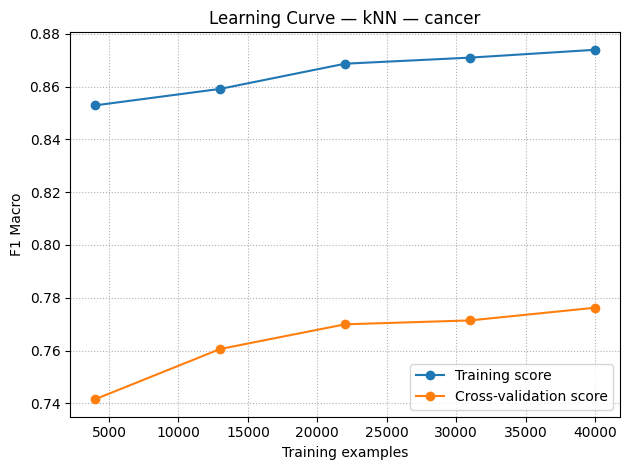

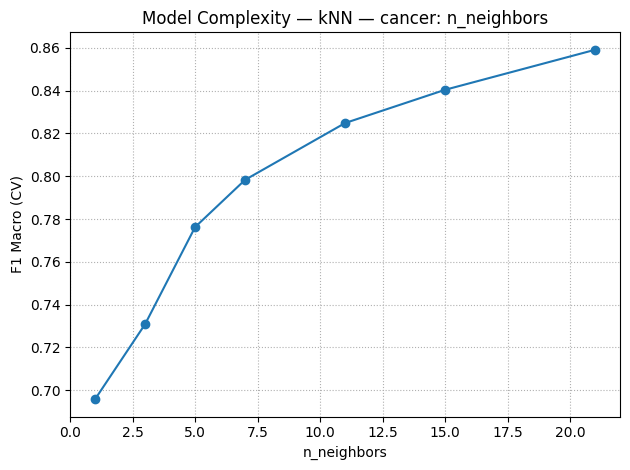

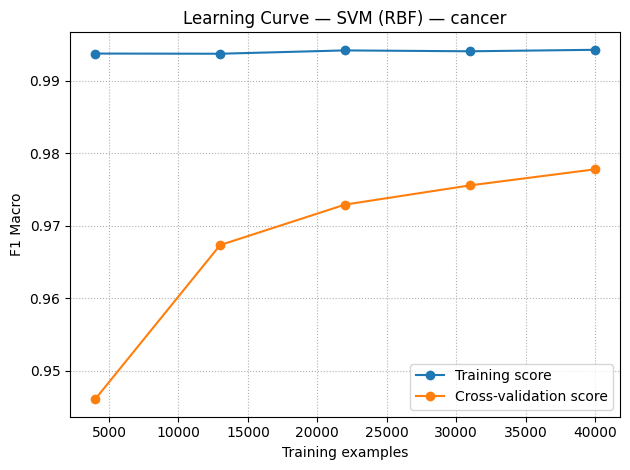

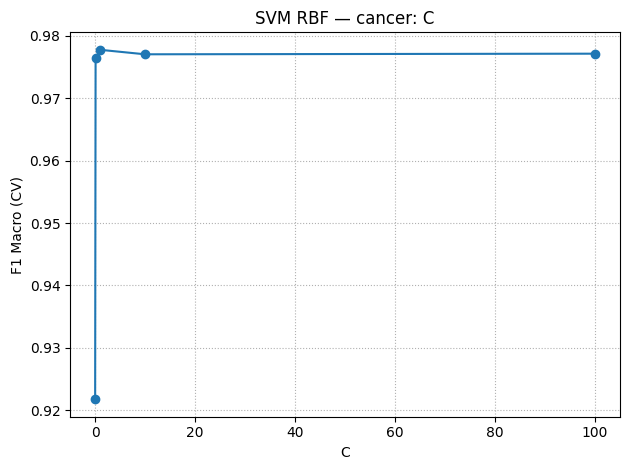

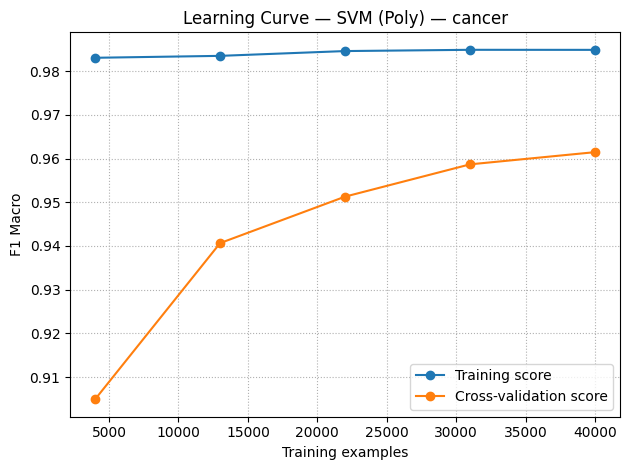

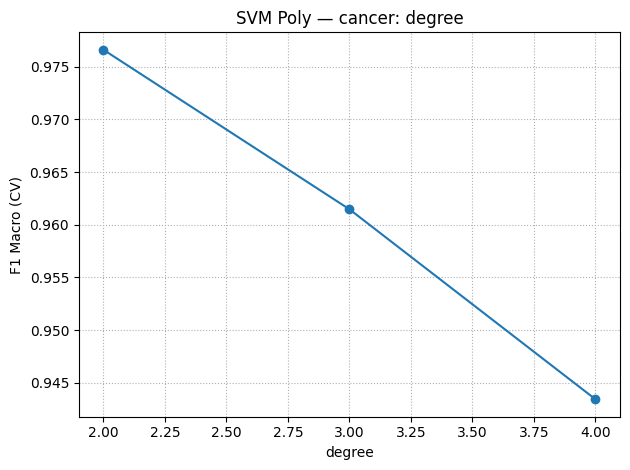

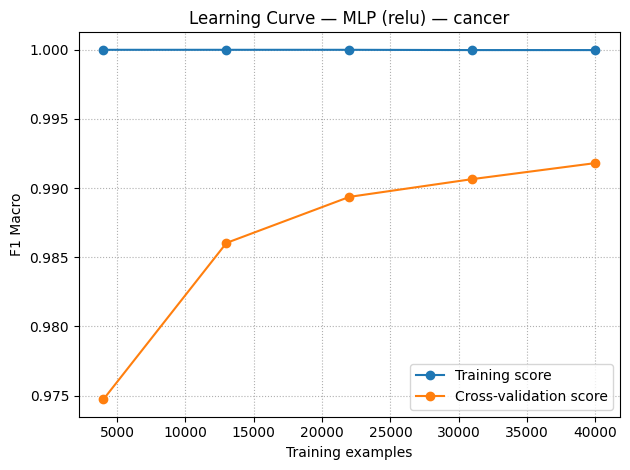

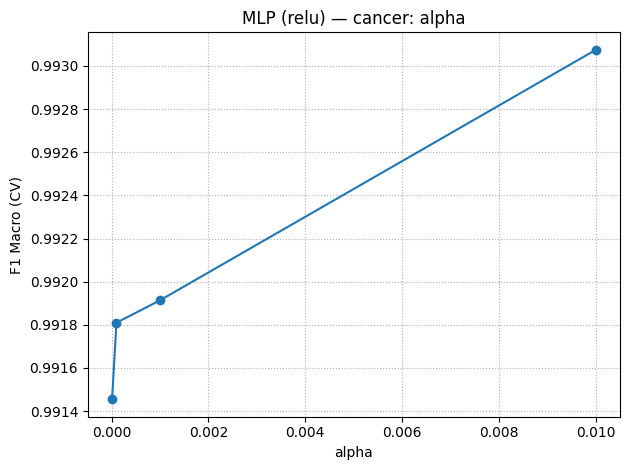

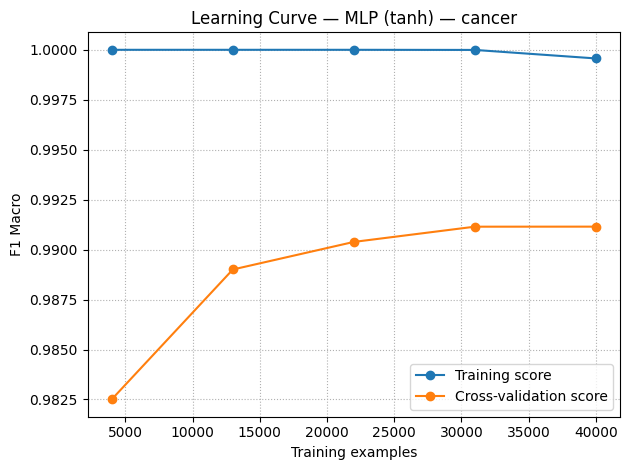

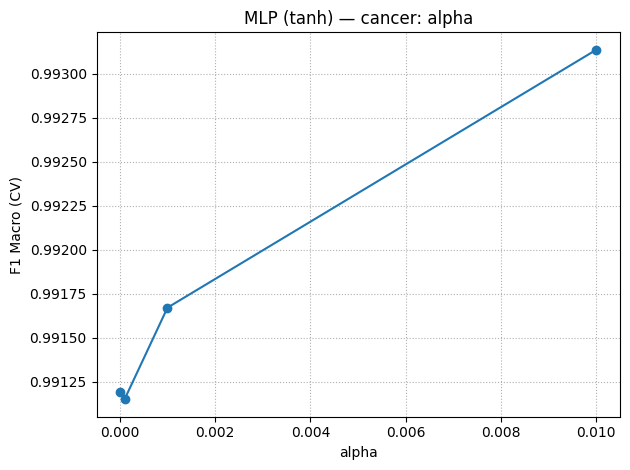

Running Bankruptcy Experiments...


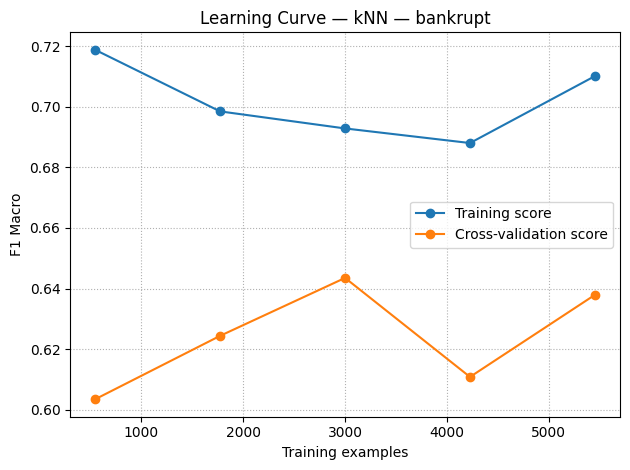

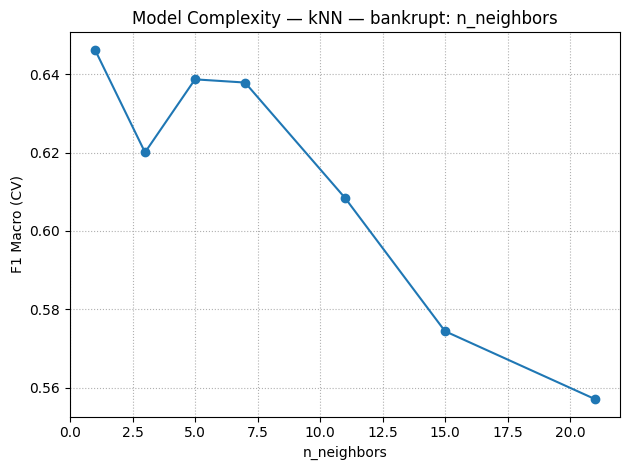

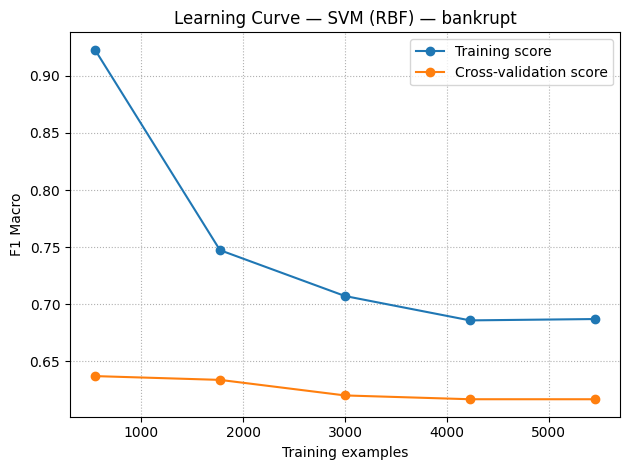

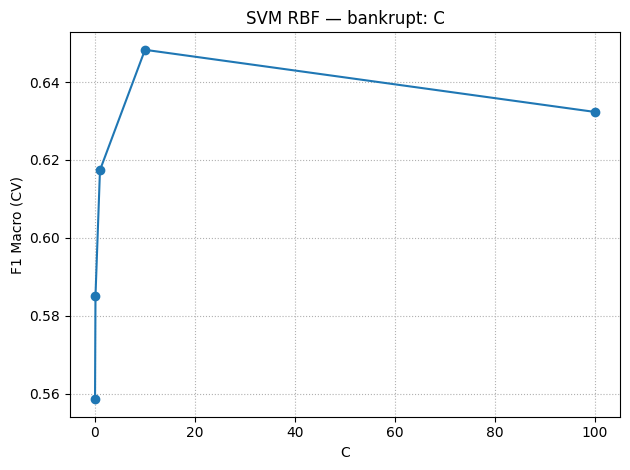

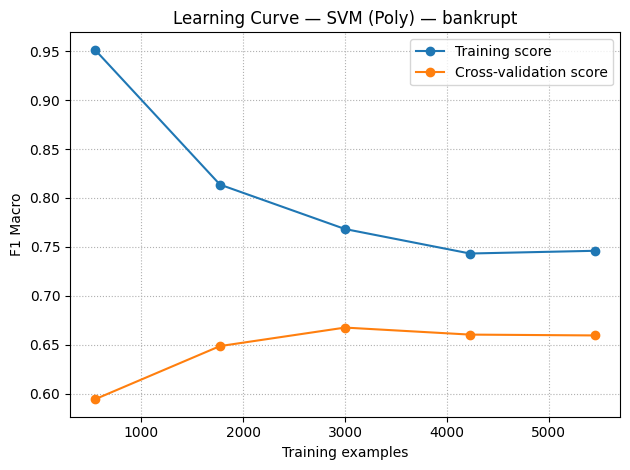

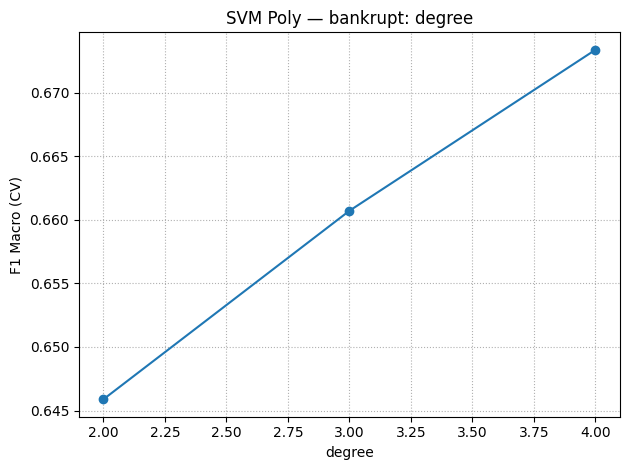

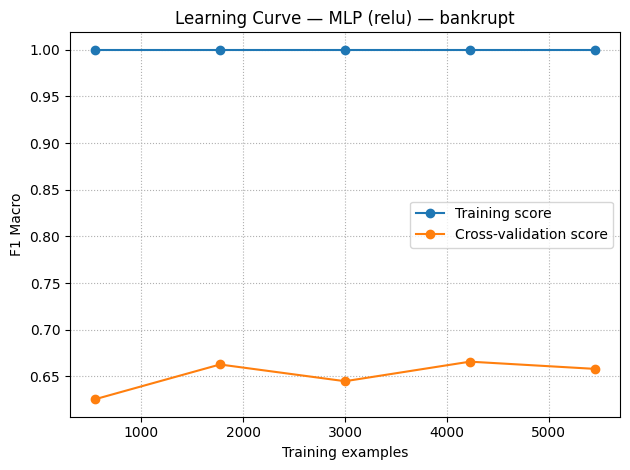

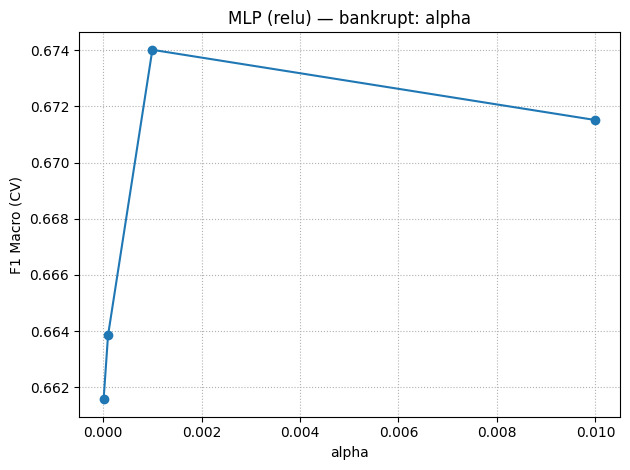

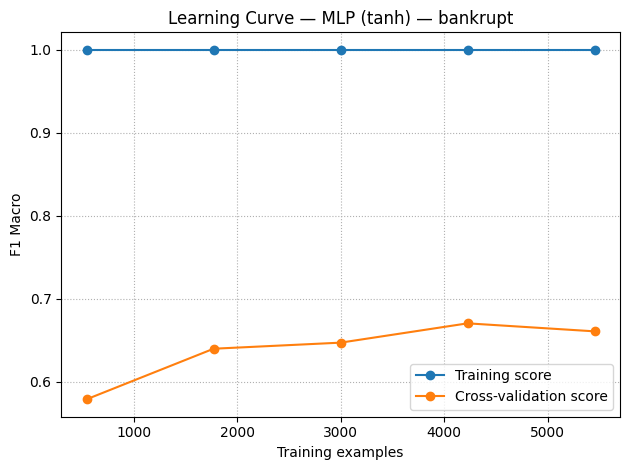

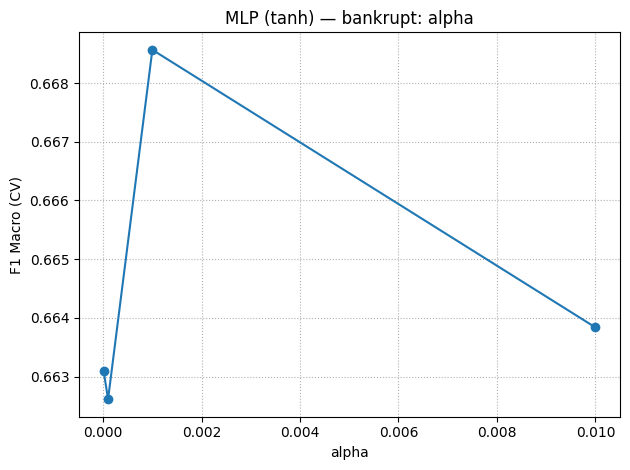

({'knn': {'accuracy': 0.7972, 'f1_macro': 0.7983019048097747, 'roc_auc': None},
  'svm_rbf': {'accuracy': 0.97718,
   'f1_macro': 0.9771597106048683,
   'roc_auc': None},
  'svm_poly': {'accuracy': 0.94298,
   'f1_macro': 0.9434422206645209,
   'roc_auc': None},
  'mlp_relu': {'accuracy': 0.99308,
   'f1_macro': 0.9930748912025749,
   'roc_auc': None},
  'mlp_tanh': {'accuracy': 0.99314,
   'f1_macro': 0.9931369828790962,
   'roc_auc': None}},
 {'knn': {'accuracy': 0.9706701862443173,
   'f1_macro': 0.6379027992837707,
   'roc_auc': 0.8035656228905206},
  'svm_rbf': {'accuracy': 0.9530722979909078,
   'f1_macro': 0.63231220301284,
   'roc_auc': 0.8526973783906652},
  'svm_poly': {'accuracy': 0.9501393166153395,
   'f1_macro': 0.6733658005486591,
   'roc_auc': 0.5833101434101585},
  'mlp_relu': {'accuracy': 0.9656841179058513,
   'f1_macro': 0.6715123173153885,
   'roc_auc': 0.8695773464298998},
  'mlp_tanh': {'accuracy': 0.9634843818741751,
   'f1_macro': 0.6638370814646133,
   'roc_au

In [14]:
cancer_df = pd.read_csv('cancer.csv')
bankrupt_df = pd.read_csv('bankruptcy.csv')

Xc, yc, pre_c = preprocess_cancer(cancer_df)
Xb, yb, pre_b = preprocess_bankruptcy(bankrupt_df)

print("Running Cancer Experiments...")
metrics_cancer = run_for_dataset("cancer", Xc, yc, pre_c)

print("Running Bankruptcy Experiments...")
metrics_bankrupt = run_for_dataset("bankrupt", Xb, yb, pre_b)

# Save metrics
with open(os.path.join(OUTDIR, "metrics_all.json"), "w") as f:
    json.dump({"cancer": metrics_cancer, "bankrupt": metrics_bankrupt}, f, indent=2)

metrics_cancer, metrics_bankrupt


In [ ]:
!brew install --cask mactex


==> Auto-updating Homebrew...
Adjust how often this is run with HOMEBREW_AUTO_UPDATE_SECS or disable with
HOMEBREW_NO_AUTO_UPDATE. Hide these hints with HOMEBREW_NO_ENV_HINTS (see `man brew`).
==> Downloading https://ghcr.io/v2/homebrew/portable-ruby/portable-ruby/blobs/sha256:20fa657858e44a4b39171d6e4111f8a9716eb62a78ebbd1491d94f90bb7b830a
######################################################################### 100.0%
==> Pouring portable-ruby-3.4.5.arm64_big_sur.bottle.tar.gz
==> Homebrew collects anonymous analytics.
Read the analytics documentation (and how to opt-out) here:
  https://docs.brew.sh/Analytics
No analytics have been recorded yet (nor will be during this `brew` run).

==> Homebrew is run entirely by unpaid volunteers. Please consider donating:
  https://github.com/Homebrew/brew#donations

==> Auto-updated Homebrew!
Updated 2 taps (homebrew/core and homebrew/cask).
==> New Formulae
abpoa: SIMD-based C library for fast partial order alignment using adaptive band
act_ru

In [ ]:
!xelatex --version

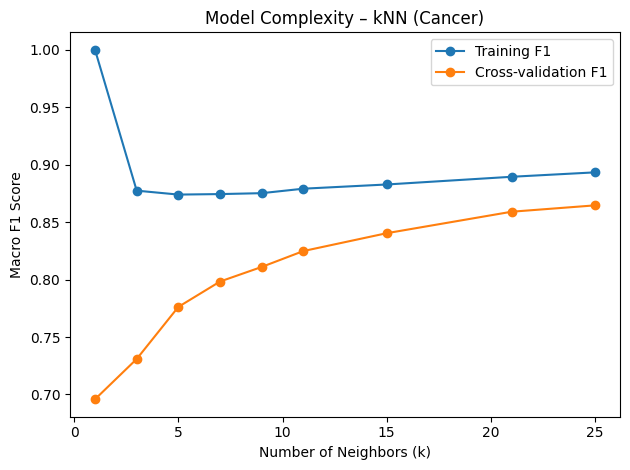

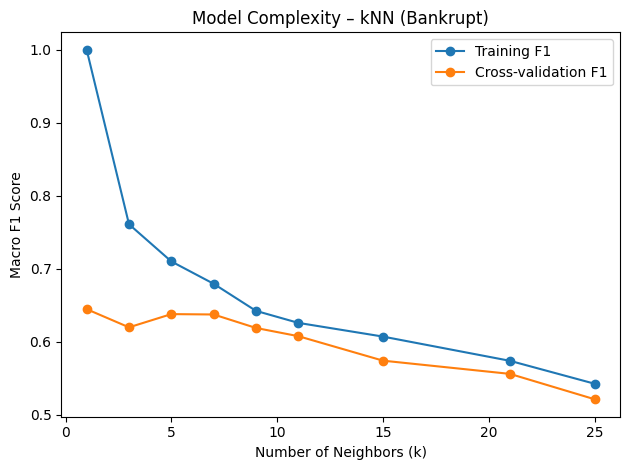

In [12]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.model_selection import StratifiedKFold, validation_curve
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import f1_score, make_scorer

def plot_knn_complexity_curve(df, dataset="cancer", target_col=None, save_path=None):
    """
    Plots kNN model complexity curve (neighbors vs. F1 score) for cancer_df or bankrupt_df.
    """

    # Step 1. Target + Features
    if dataset == "cancer":
        if "Patient_ID" in df.columns:
            df = df.drop(columns=["Patient_ID"])
        if target_col is None:
            target_col = "Target_Severity_Score"
        df["SeverityLevel"] = pd.qcut(df[target_col], q=3, labels=[0,1,2])
        y = df["SeverityLevel"]
        X = df.drop(columns=[target_col, "SeverityLevel"])
    elif dataset == "bankrupt":
        if target_col is None:
            target_col = "Bankrupt?"
        y = df[target_col]
        X = df.drop(columns=[target_col])
    else:
        raise ValueError("dataset must be 'cancer' or 'bankrupt'")

    # Step 2. Preprocessing
    if dataset == "cancer":
        categorical_cols = X.select_dtypes(include=["object", "category"]).columns.tolist()
        numeric_cols = X.select_dtypes(include=[np.number]).columns.tolist()
        numeric_tf = Pipeline(steps=[
            ("imputer", SimpleImputer(strategy="median")),
            ("scaler", StandardScaler())
        ])
        categorical_tf = Pipeline(steps=[
            ("imputer", SimpleImputer(strategy="most_frequent")),
            ("ohe", OneHotEncoder(handle_unknown="ignore"))
        ])
        preprocess = ColumnTransformer(
            transformers=[
                ("num", numeric_tf, numeric_cols),
                ("cat", categorical_tf, categorical_cols),
            ]
        )
    else:  # bankrupt = all numeric
        preprocess = Pipeline(steps=[
            ("imputer", SimpleImputer(strategy="median")),
            ("scaler", StandardScaler())
        ])

    # Step 3. kNN pipeline
    pipe = Pipeline(steps=[
        ("prep", preprocess),
        ("knn", KNeighborsClassifier())
    ])

    # Step 4. Validation curve
    param_range = [1, 3, 5, 7, 9, 11, 15, 21, 25]
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    scorer = make_scorer(f1_score, average="macro")

    train_scores, test_scores = validation_curve(
        pipe, X, y,
        param_name="knn__n_neighbors",
        param_range=param_range,
        cv=cv, scoring=scorer, n_jobs=-1
    )

    train_mean = train_scores.mean(axis=1)
    test_mean = test_scores.mean(axis=1)

    # Step 5. Plot
    plt.figure()
    plt.plot(param_range, train_mean, marker="o", label="Training F1")
    plt.plot(param_range, test_mean, marker="o", label="Cross-validation F1")
    plt.xlabel("Number of Neighbors (k)")
    plt.ylabel("Macro F1 Score")
    plt.title(f"Model Complexity – kNN ({dataset.capitalize()})")
    plt.legend()
    plt.tight_layout()

    if save_path:
        plt.savefig(save_path, dpi=200)
    plt.show()


# --- Run for Cancer dataset ---
plot_knn_complexity_curve(cancer_df, dataset="cancer", save_path="download-knn-cancer-neighbors.png")

# --- Run for Bankruptcy dataset ---
plot_knn_complexity_curve(bankrupt_df, dataset="bankrupt", save_path="download-knn-bankrupt-neighbors.png")
